# Simple Deep Learning model for semantic segmentation 
## Aerial Semantic Segmentation Drone Dataset

<font size="4">This dataset is provided by Graz University of Technology ==> [Aerial Semantic Segmentation Drone Dataset](http://dronedataset.icg.tugraz.at). It is really useful to gain wider knowledge about **Computer Vision** and **Deep Learning** techniques. In this notebook several concepts will be explained:
    <font>
- <font size="4">Tensorflow basics-intermediate commands<font>
- <font size="4">Dealing with **large Datasets**<font>
- <font size="4">Image processing with OpenCV<font>
- <font size="4">Creating **Pipelines** using data generators to avoid memory overrunning<font>
- <font size="4">Training, validation and testing sets<font>
- <font size="4">Building your own **Convolutional Neural Network (CNN)**<font>
- <font size="4">Familiarization with simple callbacks:<font>
    - <font size="4">EarlyStopping<font>
- <font size="4">Performance analysis - metrics: <font>
    - <font size="4">Confusion matrix<font>
    - <font size="4">**MIoU**...<font>
- <font size="4">Predictions visualization<font>

<font size='4'>The aim of this notebook is to perform semantic segmentation on drone images like the ones shown below.<font><font>

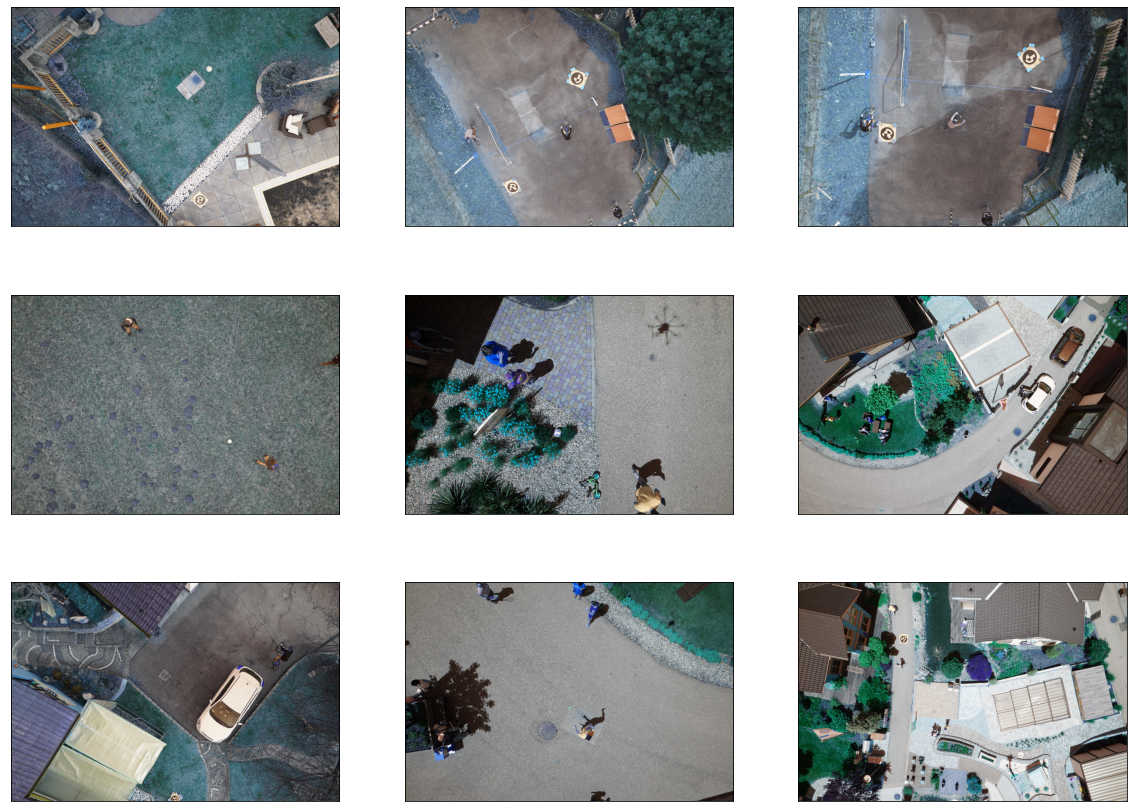

In [1]:
import os, cv2

path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'

files = []

for i in os.listdir(path)[:9]:
    files.append(os.path.join(path, i))

img=[cv2.resize(cv2.imread(files[i], 3), (1200, 800)) for i in range(len(files))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(20,15))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(img[3*i+j])
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
plt.show()

# INDEX


- [<font size="4">Setup<font>](#section-one)
- [<font size="4">Analysing the dataset<font>](#section-two)
- [<font size="4">Dataset Pipeline for preprocessing<font>](#section-three)
- [<font size="4">Convolutional Neural Network Model and Training<font>](#section-four)
- [<font size="4">Model performance<font>](#section-five)


<a id="section-one"></a>
# 1. Setup 

 <font size="4">As always, it is necessary to import **required libraries**, just basic setting up.<font>

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<a id="section-two"></a>
# 2. Analysing the dataset

<font size="4">Firstly, we should take a look to our dataset, analyse the folders structure as well as the content of each of the dataset files.
It can be seen that label images (or masks) store information from the label of each pixel as a number corresponding to each class from 0 to 23 and this is the reason why the images seems to be too dark (0-255).

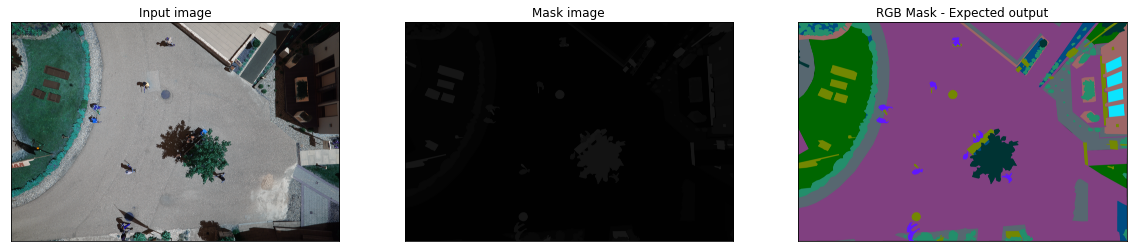

In [3]:
img = cv2.imread('../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/002.jpg', 3)
label = cv2.imread('../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/002.png', 3)
rgb = cv2.imread('../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/002.png', 3)
fig, ax = plt.subplots(1, 3, figsize=(20,6))
ax[0].imshow(img)
ax[1].imshow(label)
ax[2].imshow(rgb)
ax[0].set_title('Input image')
ax[1].set_title('Mask image')
ax[2].set_title('RGB Mask - Expected output')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
plt.show()

<font size="4">To ease the segmentation visualization, a dictionary has been incorporated to the dataset mapping each class to a specific color<font>. Below, you can see the **RGB tuple** corresponding to each class as well as the class corresponding to each number in the mask image.

In [4]:
df = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
df

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


<a id="section-three"></a>
# 3. Dataset Pipeline for preprocessing

 <font size="4"> Once we know better our dataset, we will create a **data generator** using a `tf.data.Dataset` object. Which will allow us not to run out of memory while loading all the dataset at once. What we want to do is just load the original dataset in **batches** in order to pass a lower amount of data to our Neural Network setting **free RAM memory**. You can try to load all the dataset at once to realise what the problem is.<font>
 

In [5]:
num_classes=23
H=800
W=1200

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset object from Tensorflow
    dataset = dataset.shuffle(buffer_size=100) 
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine atch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask


<font size='4'> The structure of the **Pipeline** requires the filenames and the ubication of every of them to create the **Dataset**. So, before calling the data generator we will get the **files paths**. <font>

In [6]:
root_dir = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset'
img_path = root_dir + '/original_images/'
mask_path = root_dir + '/label_images_semantic/'

names = list(map(lambda x: x.replace('.jpg', ''), os.listdir(img_path)))

<font size='4'> To make things easier we will split our data into the **training, validation and testing** set spliting the file paths array in order to waste less memory.

In [7]:
X_trainval, X_test = train_test_split(names, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(img_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(img_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(img_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]


Train Size : 288 images
Val Size   :  72 images
Test Size  :  40 images


<font size='4'> **Testing set preprocessing is quite different!!!** So we will create another Pipeline. <font>
    


In [8]:
## Dataset Pipeline used for testing the model
num_classes=23
H=800
W=1200


def test_dataset(x, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (H, W, 3))    # In the Images, number of channels = 3.  
    return image

<font size='4'>To end up with preprocessing we will set the batch size (just try the maximum value that prevents your session from crashing). The intention is to put the **bigger batch size possible**: the one that will <u>optimize the training time without running out of memory</u>.<font>

In [9]:
batch_size=3

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

<a id="section-four"></a>
# 4. Convolutional Neural Network Model and Training

<font size='4'>The model I have chosen for training is a simple U-Net. Take a look at its architecture [here](https://towardsdatascience.com/u-net-b229b32b4a71).<font>

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model

<font size='4'>Let's take a glance at the `model.summary()` which will help us to analyse the **layers dimensions**. It is specially important to take care of the **Input and Output layers** as they must match our input and expected output dimensions.

In [11]:
model = multi_unet_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 1200, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 1200, 16 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 1200, 16 2320        dropout[0][0]                    
______________________________________________________________________________________________

<font size='4'>To avoid losing time training, it is always useful to set up a `EarlyStopping` callback. There are other types of callbacks which can help you to perform different tasks while training such as saving checkpoints.<font>

In [12]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=10)

<font size='4'>Given that this model takes a lot of time to train (6 hours more less). I have pre-trained it on my computer and I will load the pretrain model in order not to fully train it on Kaggle. Here, I will just run 1 epoch to show that it works properly.<font>

In [13]:
model =  tf.keras.models.load_model('../input/pretrained-model/model.h5') 

In [14]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=1 #just to check it works properly
         )

96/96 [==============================] - 266s 3s/step - loss: 0.6688 - accuracy: 0.7977 - val_loss: 0.6793 - val_accuracy: 0.7912


<a id="section-five"></a>
# 5. Model performance
<font size='4'>To conclude, we will load our test Dataset and **evaluate our model on the test set**.<font>

In [15]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

14/14 [==============================] - 29s 2s/step - loss: 0.7532 - accuracy: 0.7681


[0.7531644105911255, 0.7680860161781311]

<font size='4'>Accuracy on the testing set is around **77%**. However, accuracy is not the better metric while doing semantic segmentation. It is commonly used the **Jaccard coefficient** also known as **MIoU (Mean Intersection over Union)**. More information about it [here](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2).<font>

In [16]:
# To visualize loss and accuracy evolution

# df = pd.DataFrame(history.history)
# df[['loss', 'acc']].plot()

<font size='4'>**Let's predict the outputs!!**<font>

In [17]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

<font size='4'>Now some post-processing is required to get the **MIoU**. We will define a function to calculate the IoU knowing the values of the confusion matrix and then it is straight-forward to calculate it.<font>

In [18]:
pred.shape

(40, 800, 1200, 23)

In [19]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (1200, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [20]:
from sklearn.metrics import confusion_matrix
color_dict = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
cm = confusion_matrix(label, predictions, labels=range(23))
df_cm = pd.DataFrame(cm,  columns=list(color_dict['name'])[:23])
df_cm

,unlabeled,paved-area,dirt,grass,gravel,water,rocks,pool,vegetation,roof,...,fence,fence-pole,person,dog,car,bicycle,tree,bald-tree,ar-marker,obstacle
0,9022,26585,1512,8262,5345,492,2,853,1843,3446,...,0,0,13,0,0,0,245,258,6,1003
1,8286,14866351,78552,62847,133090,25744,938,8430,13228,66121,...,0,0,7051,0,12,0,1893,54966,665,79558
2,837,129930,839765,117907,66761,4571,140,11,99812,804,...,0,0,672,0,0,0,1736,18273,0,3722
3,2945,46293,199799,5190386,13469,7689,28,18,37846,950,...,0,0,862,0,0,0,3646,23491,9,2614
4,1416,247854,76006,28802,2599996,6584,707,1002,64736,4624,...,0,0,580,0,0,0,406,4061,25,18826
5,768,17965,3424,55497,19886,365854,37,3162,14624,3261,...,0,0,140,0,2,0,1245,1922,339,26233
6,44,41329,26895,14696,106861,2202,967,0,24053,43,...,0,0,95,0,0,0,231,3213,0,2578
7,190,1387,0,0,1842,26,0,239620,1,62,...,0,0,15,0,0,0,0,0,281,16533
8,1734,35859,547323,341301,187573,28341,677,18,1616332,2654,...,0,0,1926,0,0,0,50128,52759,21,8814
9,2850,592369,23627,2198,53773,7277,5,171,2794,2471927,...,0,0,3000,0,60,0,358,17667,1,82010


In [21]:
def iou(cm, i):
    return cm[i,i]/(sum(cm[i])+sum(cm[:,i])-cm[i,i])

print('MIoU: {0}%'.format(round(100*np.mean(np.nan_to_num(np.array([iou(cm, i) for i in range(23)]))), 4)))

MIoU: 27.3526%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


<font size='4'>**28% MIoU**... Definitely, our model can improve quite a lot but it is a good and simple approach to a **multi-class semantic segmentation problem**. <font>

# 6. Visualize the model predictions

<font size='4'>Finally, let's see some predictions. Some post-processing is required<font>

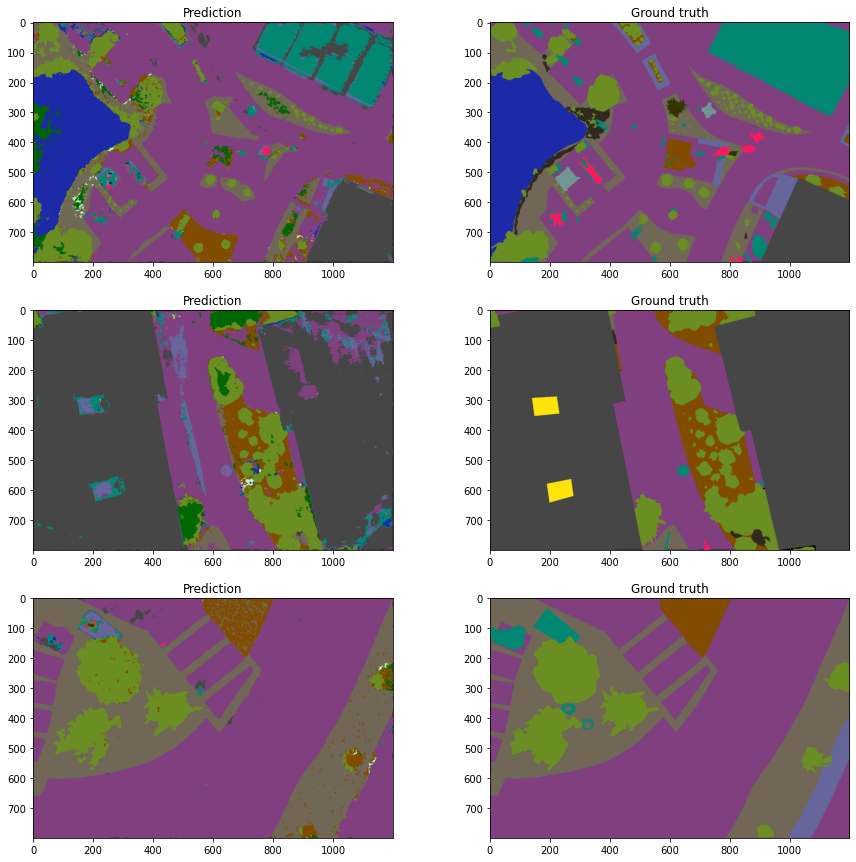

In [22]:
cmap = np.array(list(color_dict[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 1200)
label = label.reshape(-1, 800, 1200)

i = 18
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(cmap[predictions[i+j]])
    ax[j, 1].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
plt.show()

### It performs quite well!!